In [1]:
import torch
import os
import lightning as pl
from lightning.pytorch.loggers import WandbLogger
import matplotlib.pyplot as plt
import wandb
from predictor import Predictor
import random
import numpy as np


In [2]:
predictor = Predictor()
predictor.cuda();


In [3]:
class MaskPredDataset(torch.utils.data.Dataset):
    def __init__(self, data_root, split):
        self.data_path = os.path.join(data_root, split)
        self.split = split

        all_videos = os.listdir(self.data_path)
        all_videos.sort(key= lambda x: int(x.split('/')[-1].split('.')[0].split('_')[-1]))
        self.all_videos = all_videos

    def __len__(self):
        return len(self.all_videos)

    def __getitem__(self, idx):
        mask_path = os.path.join(self.data_path, self.all_videos[idx], "mask.pt")
        mask = torch.load(mask_path)
        return mask.float()


In [4]:
train_set = MaskPredDataset("data_prepared", "train")
val_set = MaskPredDataset("data_prepared", "val")


In [10]:
class MaskPredFormer(pl.LightningModule):
    def __init__(self, predictor):
        super().__init__()
        self.predictor = predictor

    def common_step(self, batch):
        x = batch[:, :-1]
        y = torch.argmax(batch[:, 1:], dim=2).long() # (b, t, h, w)
        y_hat = self.predictor(x) # (b, t, c, h, w)

        # compute loss
        b, t, *_ = y.shape
        assert b == y_hat.shape[0] and t == y_hat.shape[1], "Batch size or sequence length mismatch"

        y = y.view(b*t, *y.shape[2:])
        y_hat = y_hat.view(b*t, *y_hat.shape[2:])

        loss = torch.nn.functional.cross_entropy(y_hat, y)
        return loss, y_hat.view(b,t, *y_hat.shape[1:]), y.view(b, t, *y.shape[1:])
    
    def training_step(self, batch, batch_idx):
        loss, _, _ = self.common_step(batch)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, _, _ = self.common_step(batch)
        self.log('val_loss', loss, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=1e-3)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=50)
        return [optim], [sch]

class SampleVideoCallback(pl.pytorch.callbacks.Callback):
    def __init__(self, val_dataset):
        self.val_dataset = val_dataset

    def apply_cm(self, x):
        cm = plt.get_cmap()
        norm = plt.Normalize(vmin=x.min(), vmax=x.max())
        return cm(norm(x))[:, :, :3].transpose(2,0,1)

    def on_validation_epoch_end(self, trainer, pl_module):
        print("INFO: Sampling validation videos")
        # sample videos
        pl_module.eval()
        
        sample = self.val_dataset[random.randint(0, len(self.val_dataset))]
        sample = sample.unsqueeze(0).to(pl_module.device)
        # import pdb; pdb.set_trace()
        _, pred, gt = pl_module.common_step(sample)
        pred = pred.detach().cpu().squeeze(0)
        gt = gt.detach().cpu().squeeze(0) 
        
        # sample and log videos
        pred_imgs = []
        gt_imgs = []
        for t in range(pred.shape[0]):
            pred_img = self.apply_cm(torch.argmax(pred[t], dim=0))
            gt_img = self.apply_cm(gt[t])
            pred_imgs.append(pred_img)
            gt_imgs.append(gt_img)
        # import pdb; pdb.set_trace() 
        pred_imgs = np.stack(pred_imgs, axis=0)
        gt_imgs = np.stack(gt_imgs, axis=0)
        video = (np.concatenate([gt_imgs, pred_imgs], axis=3) * 255).astype(np.uint8)
        trainer.logger.experiment.log({
            "val_video": wandb.Video(video, fps=4, format="gif")
        })
        
    


In [11]:
logger = WandbLogger(project="mask-predformer")
sample_video_cb = SampleVideoCallback(val_set)
trainer = pl.Trainer(max_epochs=10, logger=logger, callbacks=[sample_video_cb])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(
    MaskPredFormer(predictor), 
    torch.utils.data.DataLoader(train_set, batch_size=1, num_workers=4),
    torch.utils.data.DataLoader(val_set, batch_size=1, num_workers=4),
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eneserciyes. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | predictor | Predictor | 118 M 
----------------------------------------
118 M     Trainable params
0         Non-trainable params
118 M     Total params
472.876   Total estimated model params size (MB)


Epoch 0:  46%|████▌     | 456/1000 [03:00<03:35,  2.53it/s, v_num=arsb]    

In [7]:
video = np.load("video.npy")


In [8]:
video[0].dtype


dtype('float64')

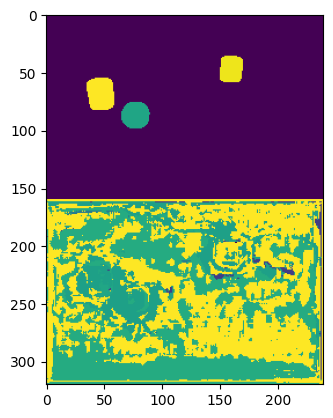

In [9]:
plt.imshow((video[0].transpose(1,2,0)*255).astype(np.uint8))
